## Task : Implement YOLO for car detection with Keras

In [1]:
import argparse
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import scipy.io
import imageio
import numpy as np
import pandas as pd
import PIL
import tensorflow.compat as tf
from keras import backend as K
from keras.layers import Input, Lambda, Conv2D
from keras.models import load_model, Model
%matplotlib inline
%config Completer.use_jedi = False

Bounding boxes details : 

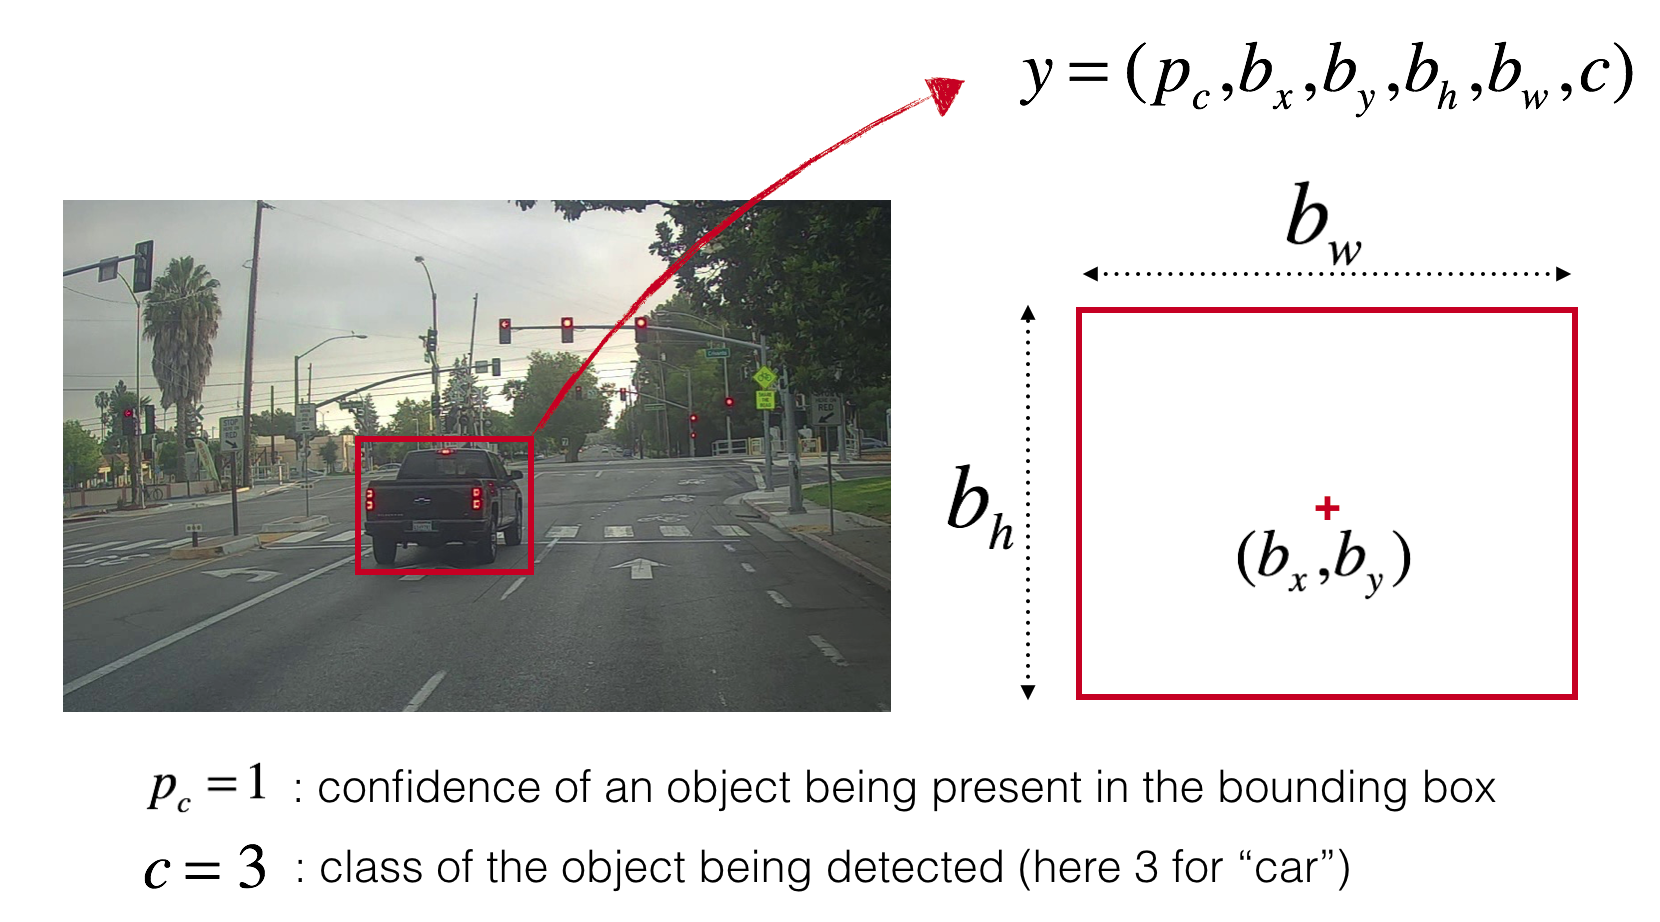

## YOLO

"You Only Look Once" (YOLO) is a popular algorithm because it achieves high accuracy while also being able to run in real-time. This algorithm "only looks once" at the image in the sense that it requires only one forward propagation pass through the network to make predictions. After non-max suppression, it then outputs recognized objects together with the bounding boxes.

### Model Details : 

#### Inputs and Outputs
   * The **input** is a batch of images and each image is of shape (m,608,608,3)
   * The **output** is a list of bounding boxes along with the recogniszed classes.
   * Each Bounding box is represented by 6 numbers: 
   
 

    #### Anchor Boxes 
   * Anchor boxes are chosen by exploring the training data to choose reasonable height/width ratios that   
     represent different classes
   * The dimensions of these anchor boxes is second to last dimension in encoding :
   


   * The YOLO architecture is: IMAGE (m, 608, 608, 3) -> DEEP CNN -> ENCODING (m, 19, 19, 5, 85). 

#### Encoding 

   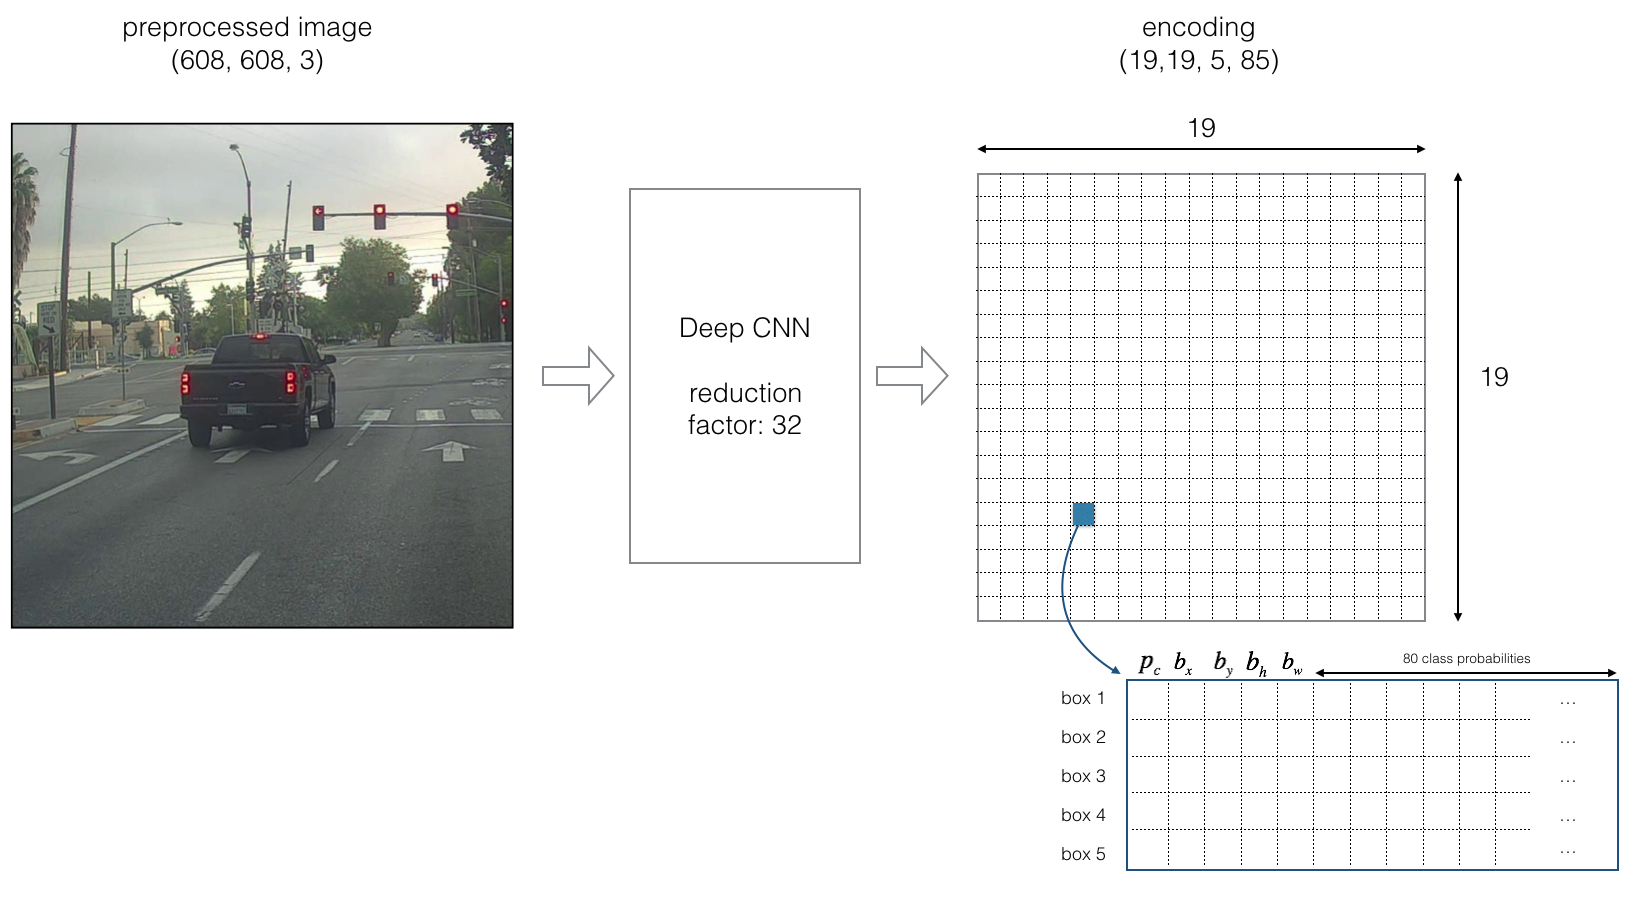
   
- **If center/midpoint of an object falls into a grid cell, that grid cell is responsible for detecting that object**

- As we will use 5 anchor boxes, each of 19x19 cells thus encodes information about 5 boxs

- For simplicity, we will flatten the last two last dimensions of the shape (19, 19, 5, 85) encoding. So the output of the Deep CNN is (19, 19, 425).

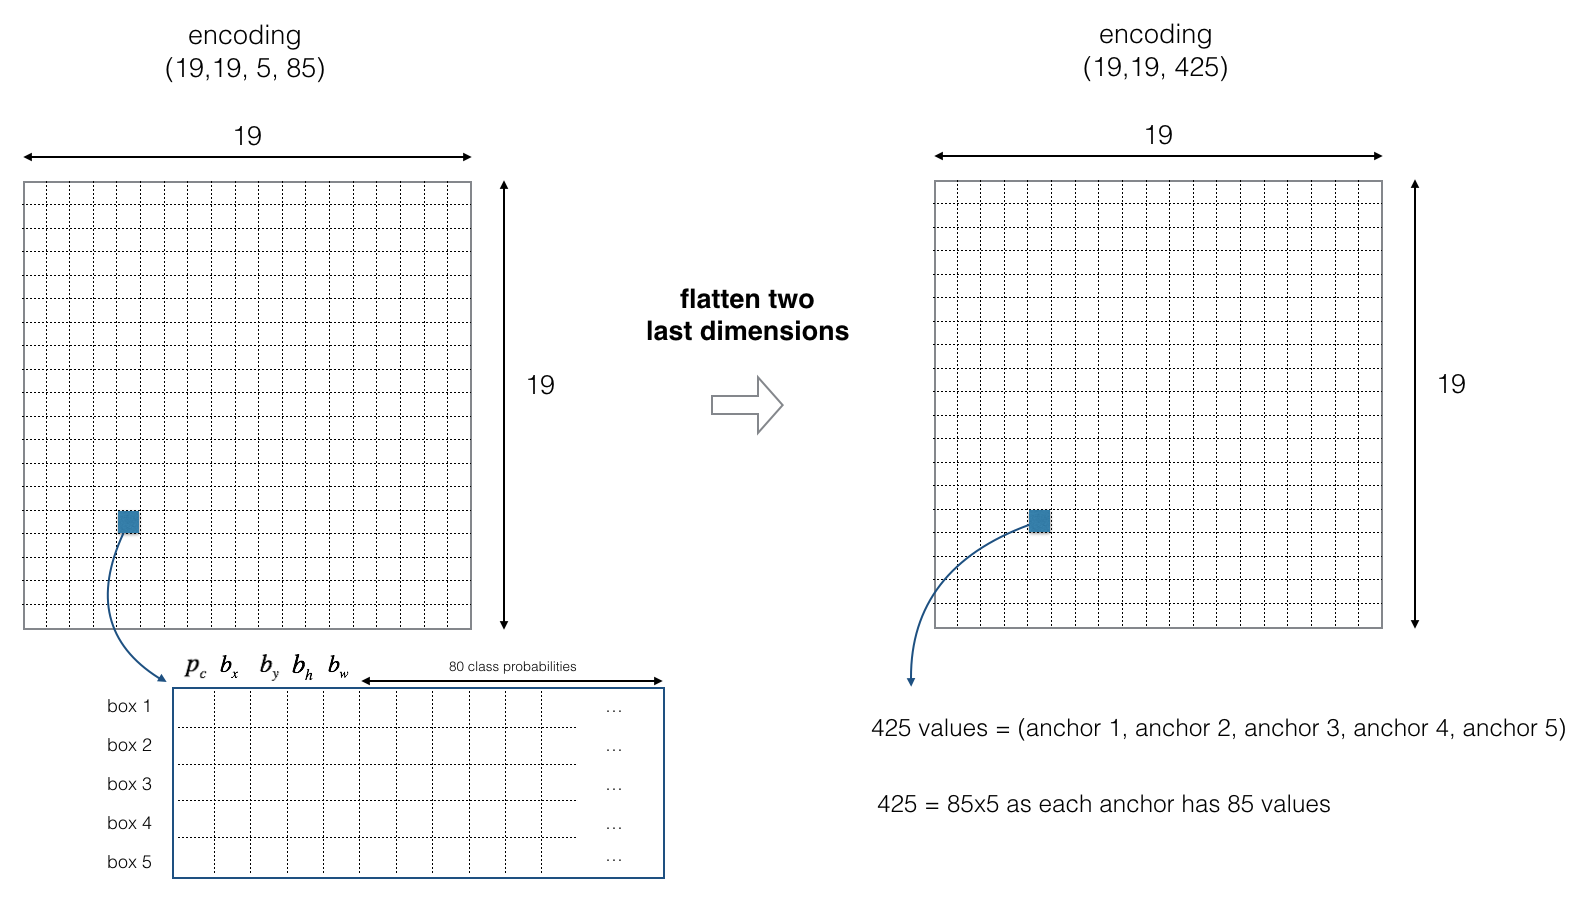

#### Class score

Now for each box we will compute the following element-wise product and extract probability that the box contains a certain class.

The class score is :

where the p is probability that object belongs to class c

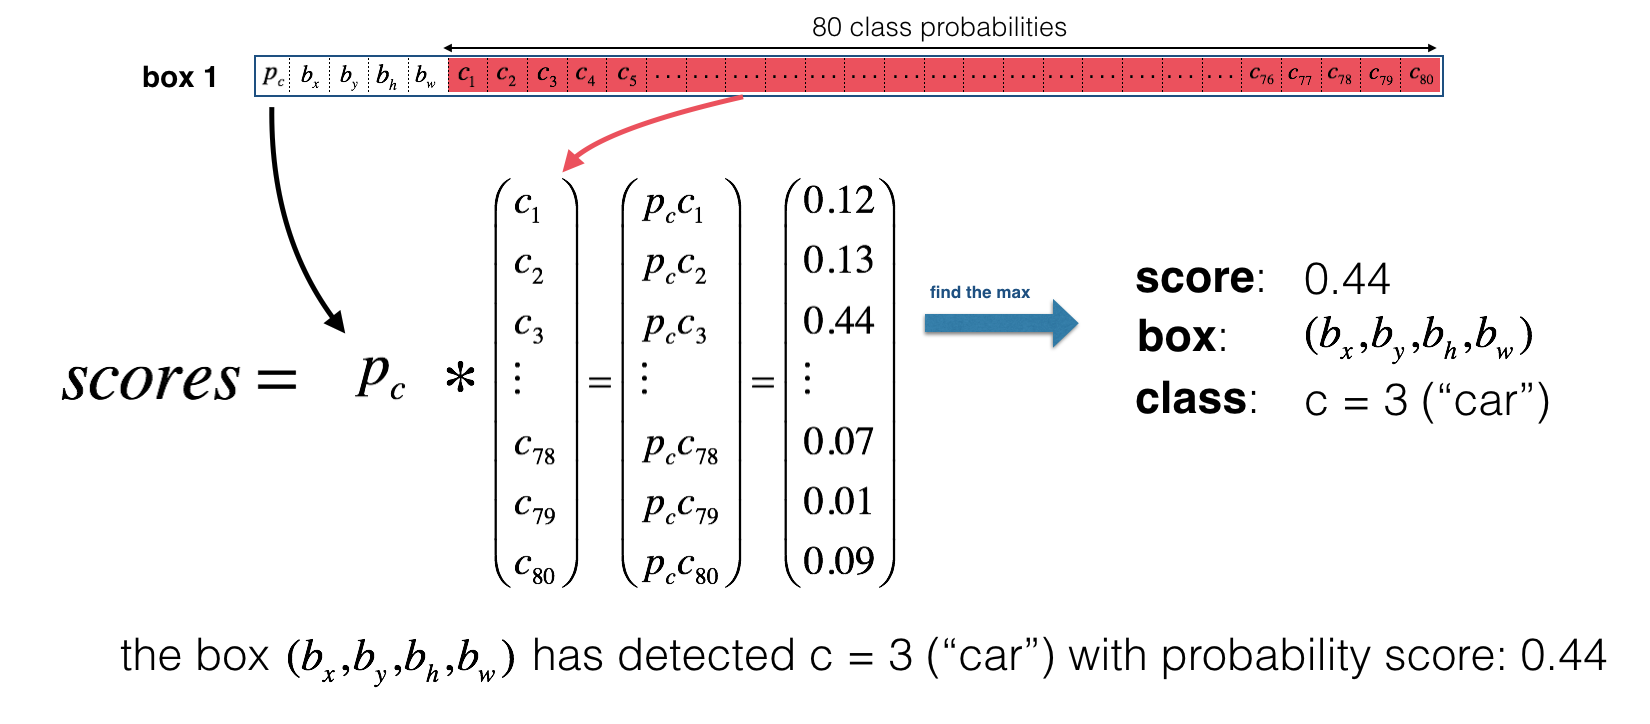

#### Non-Max Suppression

As when the YOLO plots boxes for which model has asssigned a high probability , but there are still too many boxes, thus we use non-max suppression 

   - We get rid of boxes with a low score (meaning, the box is not very confident about detecting a class; either 
     due to the low probability of any object, or low probability of this particular class).
    
   - It selects only one box when several boxes overlap with each other and detect same object

#### Implementing a filter with a threshold on class scores, to get rid of boxes which has class score less than threshold

In [35]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from keras import backend as K

In [51]:
def yolo_filter_boxes(box_confidence,boxes,box_class_probs,threshold = 0.6) : 
    
    '''
    box_confidence -- tensor of shape (19,19,5,1) contains confidence probability for each of 5 boxes predicted in each 19x19 cells
    boxes -- tensor of shape (19,19,5,1) contains the midpoint and dimensions (bx,by,bh,bw) for each of 5 boxes in each cell.
    box_class_probs -- tensor of shape (19,19,5,80) containing the class probabilities from 1 to 80th class for each of 5 boxes per cell
    threshold -- a threshold class score to pass the box test
    '''
    import tensorflow.compat.v1 as tf
    tf.disable_v2_behavior()
    from keras import backend as K
    # computing box scores
    box_scores = box_confidence * box_class_probs
    
    # finding the box_clases using max box_scores 
    box_classes = K.argmax(box_scores,axis = -1)
    box_class_scores = K.max(box_scores,axis = -1, keepdims = False)
    
    # Creating a filter mask based on box_class_scores by using threshold , mask will have same dimension as box_class_score
    filtering_mask = (box_class_scores >= threshold)
    
    # Applying the mask to box_class_scores , boxes and box_classes
    scores = tf.boolean_mask(box_class_scores,filtering_mask)
    boxes = tf.boolean_mask(boxes,filtering_mask)
    classes = tf.boolean_mask(box_classes,filtering_mask)
    
    return scores,boxes,classes

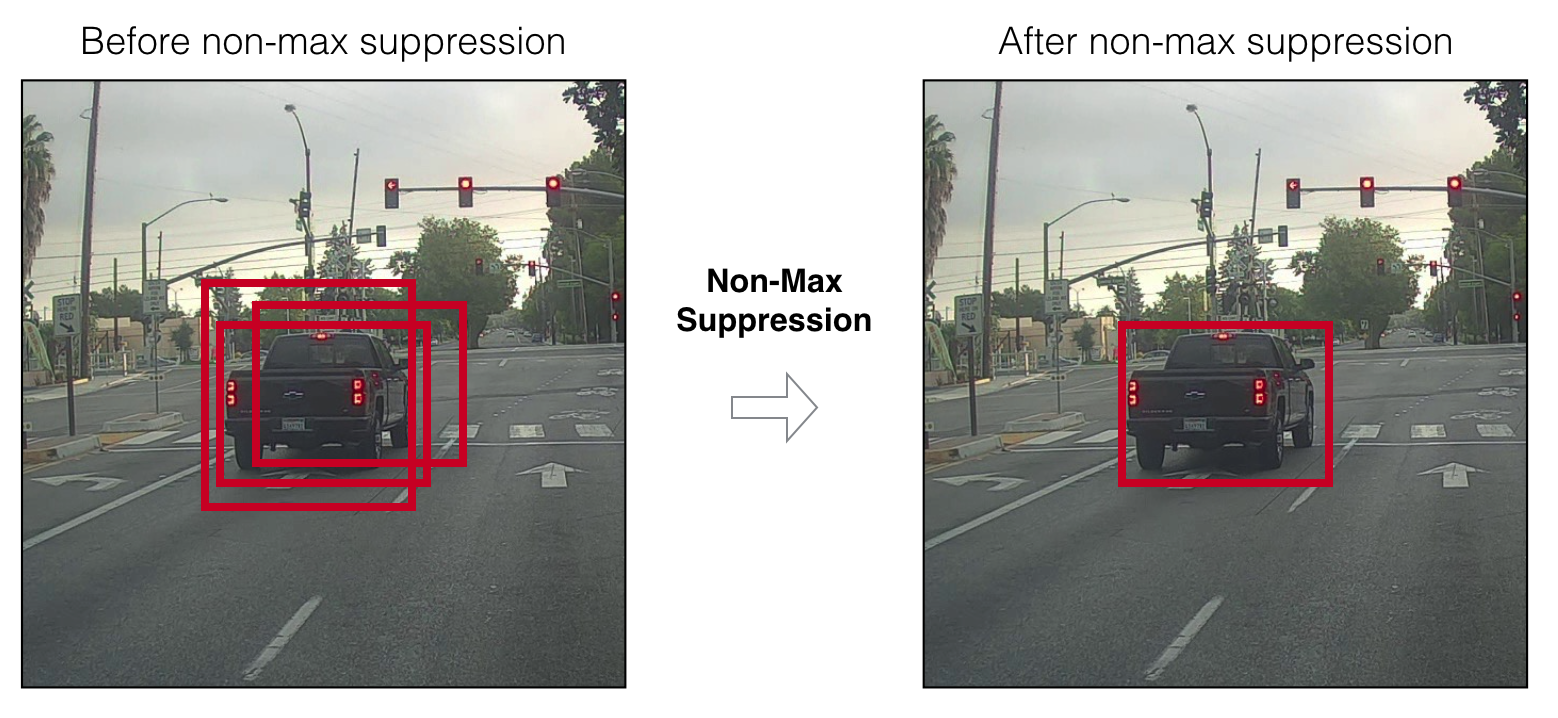


Non-max suppression uses the very important function called "Intersection over Union", or IoU. 

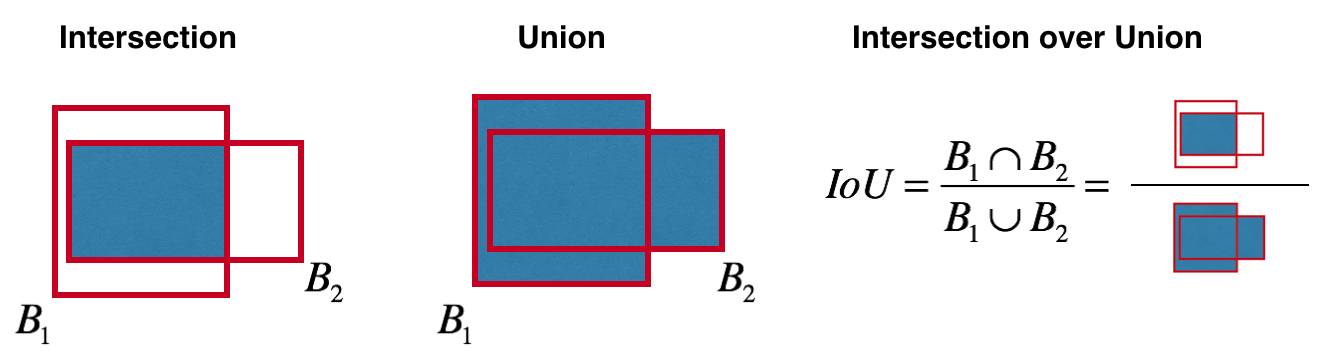

In [52]:
def iou(box1 , box2) :
    
    '''
    box1 -- first box, list object with coordinates (box1_x1, box1_y1, box1_x2, box_1_y2)
    box2 -- second box, list object with coordinates (box2_x1, box2_y1, box2_x2, box2_y2)
    '''
    
    # Assing variable names to coordinates for clarity 
    (box1_x1, box1_y1, box1_x2, box1_y2) = box1
    (box2_x1, box2_y1, box2_x2, box2_y2) = box2
    
    # Calculating the (yi1,xi1,yi2,xi2) coordinates of intersection of box1 and box2
    xi1 = np.maximum(box1_x1,box2_x1)
    yi1 = np.maximum(box1_y1,box2_y1)
    xi2 = np.minimum(box1_x2,box2_x2)
    yi2 = np.minimum(box1_y2,box2_y2)
    
    intersect_width =xi2-xi1
    intersect_height = yi2-yi1
    
    # Calculating area of intersection
    intersection_area =max(intersect_width,0) * max(intersect_height,0)
    
    # Calculating union area
    # as (AUB) = (A) + (B) -Inter(A,B)
    
    box_1_area = (box1_x2 - box1_x1) * (box1_y2 - box1_y1)
    box_2_area = (box2_x2 - box2_x1) * (box2_y2 - box2_y1)
    
    union_area = box_1_area + box_2_area - intersection_area
    
    iou = float(intersection_area)/float(union_area)
    
    return iou

Let's now implement YOLO non-max suppression

Steps to be taken care of  :

1. Select the box that has highest score
2. Compute overlap of this box with all other box and remove boxes that overlap significantly (iou >= threshold_iou)
3. Go back to step 1 and iterate until there are no more boxes with low score than currently selected box

In [68]:
def yolo_non_max_suppression(scores,boxes,classes,max_boxes = 10,iou_threshold = 0.5) :
    
    '''
    scores -- tensor of shape (None,), output of yolo_filter_boxes()
    boxes -- tensor of shape (None, 4), output of yolo_filter_boxes() that have been scaled to the image size (see later)
    classes -- tensor of shape (None,), output of yolo_filter_boxes()
    max_boxes -- integer, maximum number of predicted boxes you'd like
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering
    '''
    
    import tensorflow.compat.v1 as tf
    tf.disable_v2_behavior()
    from keras import backend as K
    sess = tf.compat.v1.keras.backend.get_session()  

    # Tensor to be used in tf.image.non_max_suppression()
    max_boxes_tensor = K.variable(max_boxes,dtype = 'int32')
    
    # initializing the variable max_boxes_tensor
    sess.run(tf.variables_initializer([max_boxes_tensor]))
    
    # Using tf.image.non_max_suppression() to get list of indices corresponding to boxes to keep
    nms_indices = tf.image.non_max_suppression(boxes,scores,max_output_size=max_boxes,iou_threshold=iou_threshold)
    
    # Using K.gather() to select only those nms_indices which we got from above 
    scores = K.gather(scores,nms_indices)
    boxes = K.gather(boxes,nms_indices)
    classes = K.gather(classes,nms_indices)
    
    return scores,boxes,classes

#### Let's implement a function taking the output of the deep CNN (the 19x19x5x85 dimensional encoding) and filtering through all the boxes using the functions we just implemented above

In [69]:
# helper functions

def scale_boxes(boxes, image_shape):
    """ Scales the predicted boxes in order to be drawable on the image"""
    
    import tensorflow.compat.v1 as tf
    tf.disable_v2_behavior()
    from keras import backend as K
    height = image_shape[0]
    width = image_shape[1]
    image_dims = K.stack([height, width, height, width])
    image_dims = K.reshape(image_dims, [1, 4])
    boxes = boxes * image_dims
    return boxes

def yolo_boxes_to_corners(box_xy, box_wh):
    """Convert YOLO box predictions to bounding box corners."""
    import tensorflow.compat.v1 as tf
    tf.disable_v2_behavior()
    from keras import backend as K
    
    
    box_mins = box_xy - (box_wh / 2.)
    
    box_maxes = box_xy + (box_wh / 2.)

    return K.concatenate([
        box_mins[..., 1:2],  # y_min
        box_mins[..., 0:1],  # x_min
        box_maxes[..., 1:2],  # y_max
        box_maxes[..., 0:1]  # x_max
    ])


In [101]:
def yolo_eval(yolo_outputs, image_shape = (720.,1280.), max_boxes = 10, score_threshold = .6, iou_threshold = .5) : 
    
    '''
    yolo_outputs -- output of the encoding model (for image_shape of (608, 608, 3)), contains 4 tensors:
                    box_confidence: tensor of shape (None, 19, 19, 5, 1)
                    box_xy: tensor of shape (None, 19, 19, 5, 2)
                    box_wh: tensor of shape (None, 19, 19, 5, 2)
                    box_class_probs: tensor of shape (None, 19, 19, 5, 80)
    
    image_shape -- tensor of shape (2,) containing the input shape, in this notebook we use (608., 608.) (has to be float32 dtype)
    
    max_boxes -- integer, maximum number of predicted boxes you'd like
    
    score_threshold -- real value, if [ highest class probability score < threshold], then get rid of the corresponding box
    
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering
    '''
    
    # Getting the details from yolo_outputs 
    box_confidence, box_xy, box_wh,box_class_probs = yolo_outputs
    
    # Converting boxes to be the same as required for filtering functions 
    boxes = yolo_boxes_to_corners(box_xy,box_wh)
    
    # Firstly filtering and getting scores,boxes and the classes
    scores,boxes,classes = yolo_filter_boxes(box_confidence,boxes,box_class_probs,score_threshold)
    
    # Scaling boxes to orignal image shape
    boxes = scale_boxes(boxes,image_shape)
    
    # Applying non max suppression
    scores,boxes,classes = yolo_non_max_suppression(scores,boxes,classes,max_boxes,iou_threshold)
    
    
    return scores,boxes,classes
    
    

### Summary for YOLO : 
   - Input image (608, 608, 3)
   - The input image goes through a CNN, resulting in a (19,19,5,85) dimensional output.
   - After flattening the last two dimensions, the output is a volume of shape (19, 19, 425):
      -  Each cell in a 19x19 grid over the input image gives 425 numbers.
       - 425 = 5 x 85 because each cell contains predictions for 5 boxes, corresponding to 5 anchor boxes, as seen in lecture.
       - 85 = 5 + 80 where 5 is because $(p_c, b_x, b_y, b_h, b_w)$ has 5 numbers, and 80 is the number of classes we'd like to detect
   - You then select only few boxes based on:
     -   Score-thresholding: throw away boxes that have detected a class with a score less than the threshold
      -  Non-max suppression: Compute the Intersection over Union and avoid selecting overlapping boxes
    

This gives us YOLO's final output.



In [102]:
sess = tf.compat.v1.keras.backend.get_session()  

## We will be using a pre trained Yolo model as it takes a long time to train one


In [103]:
from keras.layers import Input, Lambda, Conv2D
from keras.models import load_model, Model
from yolo_utils import read_classes, read_anchors, generate_colors, preprocess_image, draw_boxes, scale_boxes
from keras_yolo import yolo_head, yolo_boxes_to_corners, preprocess_true_boxes, yolo_loss, yolo_body


In [104]:
class_names = read_classes("model_data_yolo//coco_classes.txt")
anchors = read_anchors("model_data_yolo//yolo_anchors.txt")
image_shape = (720., 1280.)


In [106]:
yolo_model = load_model('model_data_yolo/yolo.h5')

In [107]:
# let's look at summary

In [108]:
yolo_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, None, None, 3 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [109]:
class_names = np.array(class_names)

In [110]:
type(anchors)

numpy.ndarray

In [111]:
# Converting output of model to usable bounding box tensors using helper function
yolo_outputs = yolo_head(yolo_model.output[0],anchors,81)

#### Filtering boxes

yolo_outputs gave you all the predicted boxes of yolo_model in the correct format. 
now let's get best boxes from yolo_eval

In [112]:
box_confidence, box_xy, box_wh, box_class_probs = yolo_outputs
yolo_outputs = (box_wh, box_confidence, box_xy, box_class_probs)

In [113]:
scores, boxes, classes = yolo_eval(yolo_outputs, image_shape)

#### Running the graph on an image
Our graph is like this : 
1. graph is given to yolo_model to compute output
2. then it is processed by yolo_head
3. then we pass it through the filtering function yolo_eval() , which outputs our predictions

In [116]:


def predict(sess, image_file):
    """
    Runs the graph stored in "sess" to predict boxes for "image_file". Prints and plots the predictions.
    
    Arguments:
    sess -- your tensorflow/Keras session containing the YOLO graph
    image_file -- name of an image stored in the "images" folder.
    """
    
    import tensorflow.compat.v1 as tf
    tf.disable_v2_behavior()
    from keras import backend as K

    # Preprocess your image
    image, image_data = preprocess_image("images/" + image_file, model_image_size = (608, 608))

    # Run the session with the correct tensors and choose the correct placeholders in the feed_dict.
    out_scores, out_boxes, out_classes = sess.run([scores, boxes,classes], feed_dict={yolo_model.input: image_data, K.learning_phase(): 0})
   

    # Print predictions info
    print('Found {} boxes for {}'.format(len(out_boxes), image_file))
    # Generate colors for drawing bounding boxes.
    colors = generate_colors(class_names)
    # Draw bounding boxes on the image file
    draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors)
    # Save the predicted bounding box on the image
    image.save(os.path.join("out", image_file), quality=90)
    # Display the results in the notebook
    output_image = imageio.imread(os.path.join("out", image_file))
    imshow(output_image)
    
    return out_scores, out_boxes, out_classes



In [117]:
## Implement in pytorch, tensorflow is so much complex.. I am fed up with it 